<a href="https://colab.research.google.com/github/VemPrava/FMML_Projects_and_Labs/blob/main/Pravallika_FMML_M1L3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

FMML Module 1, Lab 3

In this lab, we will see how augmentation of data samples help in improving the machine learning performance. Augmentation is the process of creating new data samples by making reasonable modifications to the original data samples. This is particularly useful when the size of the training data is small. We will use the MNISt dataset for this lab. We will also reuse functions from the previous labs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp

rng = np.random.default_rng(seed=42)

In [2]:
# loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# normalizing the data
train_X = train_X / 255
test_X = test_X / 255

# subsample from images and labels. Otherwise it will take too long!
train_X = train_X[::1200, :, :].copy()
train_y = train_y[::1200].copy()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let us borrow a few functions from the previous labs:

In [4]:
def NN1(traindata, trainlabel, query):
    """
    This function takes in the training data, training labels and a query point
    and returns the predicted label for the query point using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    query: numpy array of shape (d,) where d is the number of features

    returns: the predicted label for the query point which is the label of the training data which is closest to the query point
    """
    diff = (
        traindata - query
    )  # find the difference between features. Numpy automatically takes care of the size here
    sq = diff * diff  # square the differences
    dist = sq.sum(1)  # add up the squares
    label = trainlabel[np.argmin(dist)]
    return label


def NN(traindata, trainlabel, testdata):
    """
    This function takes in the training data, training labels and test data
    and returns the predicted labels for the test data using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    testdata: numpy array of shape (m,d) where m is the number of test samples and d is the number of features

    returns: the predicted labels for the test data which is the label of the training data which is closest to each test point
    """
    traindata = traindata.reshape(-1, 28*28)
    testdata = testdata.reshape(-1, 28*28)
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel


def Accuracy(gtlabel, predlabel):
    """
    This function takes in the ground-truth labels and predicted labels
    and returns the accuracy of the classifier

    gtlabel: numpy array of shape (n,) where n is the number of samples
    predlabel: numpy array of shape (n,) where n is the number of samples.

    returns: the accuracy of the classifier which is the number of correct predictions divided by the total number of predictions
    """
    assert len(gtlabel) == len(
        predlabel
    ), "Length of the ground-truth labels and predicted labels should be the same"
    correct = (
        gtlabel == predlabel
    ).sum()  # count the number of times the groundtruth label is equal to the predicted label.
    return correct / len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time. Let us first check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [5]:
testpred = NN(train_X, train_y, test_X)
print("Baseline accuracy without augmentation:",
      Accuracy(test_y, testpred)*100, "%")

Baseline accuracy without augmentation: 64.72 %


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. So, we will use the following augmentations:

### Augmentation 1: Rotation

Let us try rotating the image a little. We will use the `rotate` function from the `skimage` module. We will rotate the image by 10 degrees and -10 degrees. Rotation is a reasonable augmentation because the digit will still be recognizable even after rotation and is representative of the dataset.

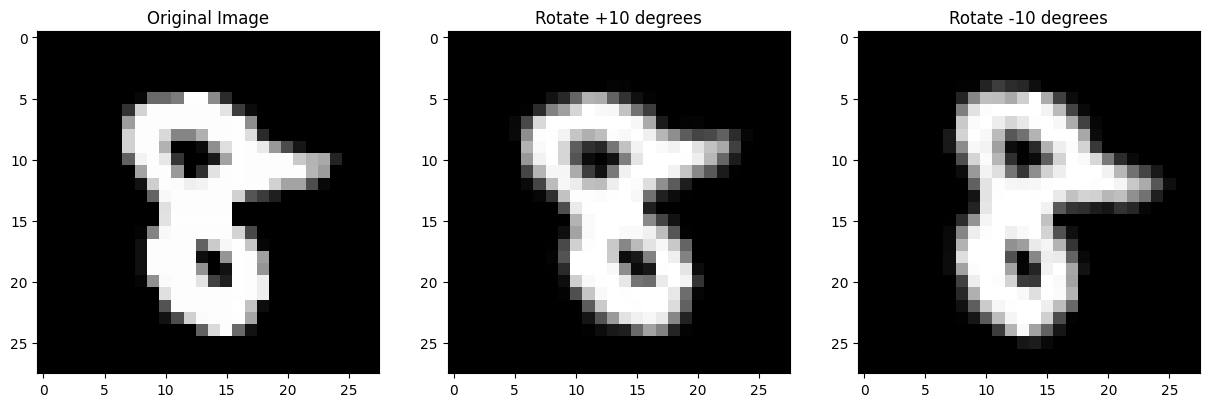

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(train_X[2], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(rotate(train_X[2], 10), cmap="gray")
axs[1].set_title("Rotate +10 degrees")

axs[2].imshow(rotate(train_X[2], -10), cmap="gray")
axs[2].set_title("Rotate -10 degrees")

plt.show()

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [7]:
def augRotate(sample, angleconstraint):
    """
    This function takes in a sample and an angle constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint
    """
    if angleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(sample[ii], angle[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

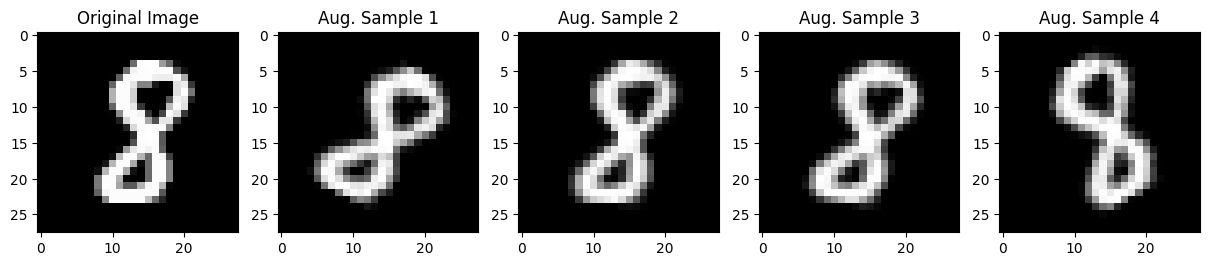

In [10]:
sample = train_X[20]
angleconstraint = 70

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[1].set_title("Aug. Sample 1")

axs[2].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[2].set_title("Aug. Sample 2")

axs[3].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[3].set_title("Aug. Sample 3")

axs[4].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[4].set_title("Aug. Sample 4")

plt.show()

Let us augment the whole dataset and see if this improves the test accuracy

In [11]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X  # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
    augdata = np.concatenate(
        (augdata, augRotate(train_X, angleconstraint))
    )  # concatenate the augmented data to the set
    auglabel = np.concatenate(
        (auglabel, train_y)
    )  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print("Accuracy after rotation augmentation:", Accuracy(test_y, testpred)*100, "%")

Accuracy after rotation augmentation: 66.75999999999999 %


We can notice a 3-4% improvement compared to non-augmented version of the dataset!

The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint. We will try angles between 0 and 90 degrees. We can also try different multiples of the original dataset. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [12]:
angleconstraints = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # the values we want to test
accuracies = np.zeros(
    len(angleconstraints), dtype=float
)  # we will save the values here

for ii in range(len(angleconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotate(train_X, angleconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after rotation augmentation constrained by",
        angleconstraints[ii],
        "degrees is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after rotation augmentation constrained by 0 degrees is 64.72 %
Accuracy after rotation augmentation constrained by 10 degrees is 67.78999999999999 %
Accuracy after rotation augmentation constrained by 20 degrees is 67.49000000000001 %
Accuracy after rotation augmentation constrained by 30 degrees is 67.55 %
Accuracy after rotation augmentation constrained by 40 degrees is 68.16 %
Accuracy after rotation augmentation constrained by 50 degrees is 66.13 %
Accuracy after rotation augmentation constrained by 60 degrees is 66.36 %
Accuracy after rotation augmentation constrained by 70 degrees is 65.85 %
Accuracy after rotation augmentation constrained by 80 degrees is 66.2 %
Accuracy after rotation augmentation constrained by 90 degrees is 65.91 %


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

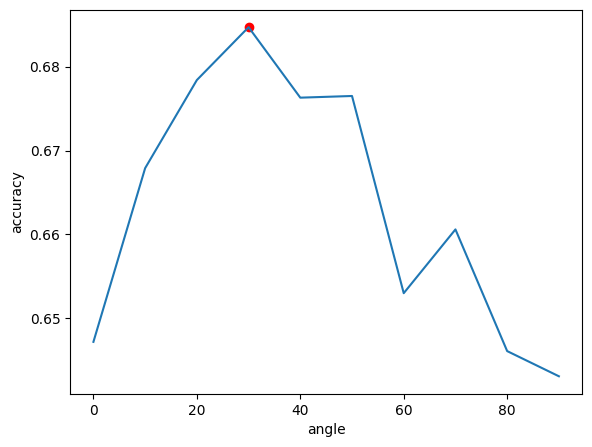

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 2: Shear


Let us try one more augmentation: shear. Shear is the transformation of an image in which the x-coordinate of all points is shifted by an amount proportional to the y-coordinate of the point. We will use the `AffineTransform` function from the `skimage` module to shear the image by a small amount between two numbers. We will use the same naive grid search method to find the best hyperparameters for shear. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [14]:
def shear(sample, amount):
    """
    This function takes in a sample and an amount and returns the augmented sample
    by shearing the sample by the given amount

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    amount: the amount by which the sample should be sheared

    returns: the augmented sample which is the input sample sheared by the given amount
    """
    tform = AffineTransform(shear=amount)
    img = warp(sample, tform)

    # Applying shear makes the digit off-center
    # Since all images are centralized, we will do the same here
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
        yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
        img = np.roll(img, (xshift, yshift), (0, 1))
    return img

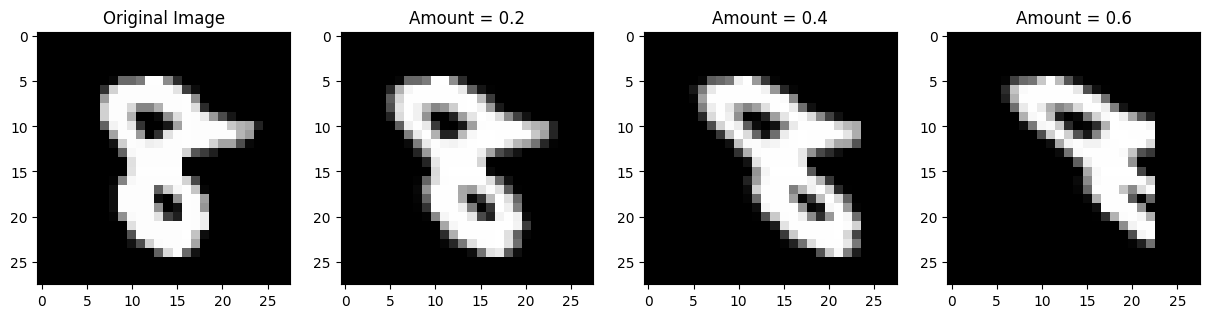

In [15]:
sample = train_X[2]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(shear(sample, 0.2), cmap="gray")
axs[1].set_title("Amount = 0.2")

axs[2].imshow(shear(sample, 0.4), cmap="gray")
axs[2].set_title("Amount = 0.4")

axs[3].imshow(shear(sample, 0.6), cmap="gray")
axs[3].set_title("Amount = 0.6")

plt.show()

Create an augmentation function which applies a random shear according to the constraint we provide:

In [16]:
def augShear(sample, shearconstraint):
    """
    This function takes in a sample and a shear constraint and returns the augmented sample
    by shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample sheared by a random amount within the shear constraint
    """
    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = shear(sample[ii], amt[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [17]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
    1.8,
    2.0,
]  # the values we want to test
accuracies = np.zeros(
    len(shearconstraints), dtype=float
)  # we will save the values here

for ii in range(len(shearconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augShear(train_X, shearconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after shear augmentation constrained by",
        shearconstraints[ii],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0.2 is 63.239999999999995 %
Accuracy after shear augmentation constrained by 0.4 is 64.22 %
Accuracy after shear augmentation constrained by 0.6 is 66.35 %
Accuracy after shear augmentation constrained by 0.8 is 65.79 %
Accuracy after shear augmentation constrained by 1.0 is 64.3 %
Accuracy after shear augmentation constrained by 1.2 is 65.21000000000001 %
Accuracy after shear augmentation constrained by 1.4 is 63.43 %
Accuracy after shear augmentation constrained by 1.6 is 63.43 %
Accuracy after shear augmentation constrained by 1.8 is 62.4 %
Accuracy after shear augmentation constrained by 2.0 is 63.33 %


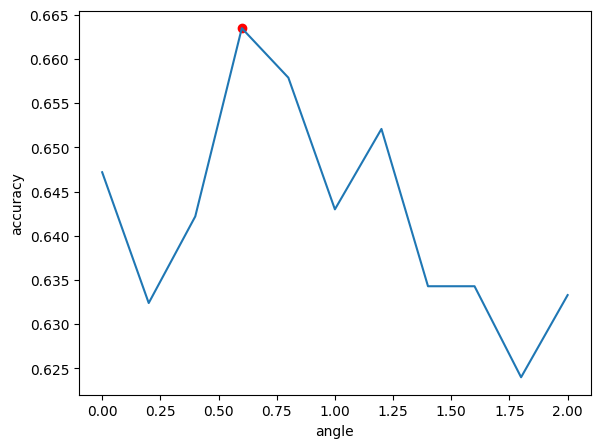

In [18]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 3: Rotation + Shear



We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [19]:
def augRotateShear(sample, angleconstraint, shearconstraint):
    """
    This function takes in a sample, an angle constraint and a shear constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint and shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint and sheared by a random amount within the shear constraint
    """
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(
            shear(sample[ii], amt[ii]), angle[ii]
        )  # first apply shear, then rotate
    return np.squeeze(nsample)  # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [20]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
]  # the values we want to test
angleconstraints = [0, 10, 20, 30, 40, 50, 60]  # the values we want to test
# cartesian product of both
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=float)  # we will save the values here

for ii in range(len(hyp)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "angle:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation shear: 0.0 angle: 0.0 is 63.32 %
Accuracy after augmentation shear: 0.0 angle: 10.0 is 62.580000000000005 %
Accuracy after augmentation shear: 0.0 angle: 20.0 is 61.11 %
Accuracy after augmentation shear: 0.0 angle: 30.0 is 62.56 %
Accuracy after augmentation shear: 0.0 angle: 40.0 is 61.870000000000005 %
Accuracy after augmentation shear: 0.0 angle: 50.0 is 61.339999999999996 %
Accuracy after augmentation shear: 0.0 angle: 60.0 is 62.74999999999999 %
Accuracy after augmentation shear: 0.2 angle: 0.0 is 63.36000000000001 %
Accuracy after augmentation shear: 0.2 angle: 10.0 is 62.480000000000004 %
Accuracy after augmentation shear: 0.2 angle: 20.0 is 63.04 %
Accuracy after augmentation shear: 0.2 angle: 30.0 is 62.83 %
Accuracy after augmentation shear: 0.2 angle: 40.0 is 63.27 %
Accuracy after augmentation shear: 0.2 angle: 50.0 is 62.28 %
Accuracy after augmentation shear: 0.2 angle: 60.0 is 62.760000000000005 %
Accuracy after augmentation shear: 0.4 angle:

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

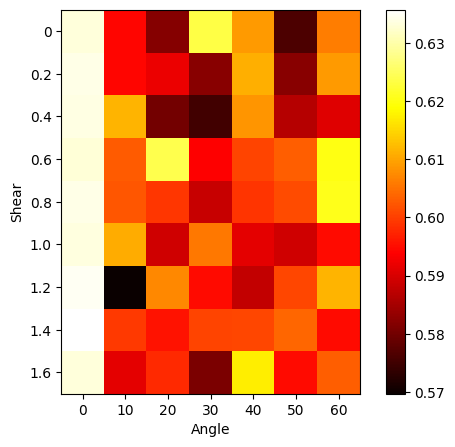

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Shear")
ax.set_xticks(np.arange(len(angleconstraints)))
ax.set_xticklabels(angleconstraints)
ax.set_yticks(np.arange(len(shearconstraints)))
ax.set_yticklabels(shearconstraints)
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

> Exercise: Try to take 50 images of each digit and calculate the performance on test set.

In [26]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.preprocessing.image import img_to_array, array_to_img

# Load the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Normalize the data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


Image unit 50 images per digit code

In [28]:
# Subset the training data to 50 images per digit
indices = []
for digit in range(10):
    digit_indices = np.where(np.argmax(y_train, axis=1) == digit)[0][:50]
    indices.extend(digit_indices)

X_train_50 = X_train[indices]
y_train_50 = y_train[indices]

# Define the model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_50, y_train_50, validation_data=(X_test, y_test), epochs=10)

# Evaluate the model
accuracy_50 = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Accuracy with 50 images per digit: {accuracy_50:.4f}")

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.3785 - loss: 1.9454 - val_accuracy: 0.7414 - val_loss: 0.9415
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.8533 - loss: 0.5923 - val_accuracy: 0.8109 - val_loss: 0.5890
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.8934 - loss: 0.3109 - val_accuracy: 0.8430 - val_loss: 0.5056
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.9313 - loss: 0.1985 - val_accuracy: 0.8506 - val_loss: 0.4868
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9616 - loss: 0.1359 - val_accuracy: 0.8660 - val_loss: 0.4469
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9775 - loss: 0.0979 - val_accuracy: 0.8641 - val_loss: 0.4742
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.9949 - loss: 0.0587 - val_accuracy: 0.8730 - val_loss: 0.4473
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9949 - loss: 0.0465 - val_accuracy: 0.

In [44]:
indices = []
for digit in range(10):
    digit_indices = np.where(np.argmax(y_train, axis=1) == digit)[0][:50]
    indices.extend(digit_indices)

X_train_50 = X_train[indices]
y_train_50 = y_train[indices]

Implimentation of augmentation


In [29]:
import numpy as np
from keras.preprocessing.image import array_to_img, img_to_array
from scipy.ndimage import rotate, shift

def rotate_image(image, angle):
    return rotate(image, angle, reshape=False)

def shear_image(image, shear_factor):
    transform_matrix = np.array([[1, shear_factor, 0], [0, 1, 0], [0, 0, 1]])
    return np.dot(transform_matrix, np.array([image.shape[0], image.shape[1], 1]))

def augment_image(image, angle=0, shear_factor=0):
    image = rotate_image(image, angle)
    if shear_factor != 0:
        image = shear_image(image, shear_factor)
    return image

In [32]:
import numpy as np
from keras.preprocessing.image import array_to_img, img_to_array
from scipy.ndimage import rotate, shift, affine_transform

def rotate_image(image, angle):
    return rotate(image, angle, reshape=False)

def shear_image(image, shear_factor):
    # Use affine_transform for shearing
    transform_matrix = np.array([[1, shear_factor, 0], [0, 1, 0]])
    return affine_transform(image, transform_matrix)

def augment_image(image, angle=0, shear_factor=0):
    image = rotate_image(image, angle)
    if shear_factor != 0:
        image = shear_image(image, shear_factor)
    return image

In [36]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical

# Load and prepare the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Subset the training data to 50 images per digit
indices = []
for digit in range(10):
    digit_indices = np.where(np.argmax(y_train, axis=1) == digit)[0][:50]
    indices.extend(digit_indices)

X_train_50 = X_train[indices]
y_train_50 = y_train[indices]


In [37]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# Define the model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [38]:
from scipy.ndimage import rotate, shift

# Define the augmentation functions
def rotate_image(image, angle):
    return rotate(image, angle, reshape=False)

def shear_image(image, shear_factor):
    # Updated shear implementation using shift
    shift_matrix = np.array([[1, shear_factor], [0, 1]])
    # Apply shear using affine transformation
    return shift(image, (shift_matrix[0, 1], shift_matrix[1, 0], 0), mode='nearest')

def augment_image(image, angle=0, shear_factor=0):
    image = rotate_image(image, angle)
    if shear_factor != 0:
        image = shear_image(image, shear_factor)
    return image


In [47]:
# Parameters for augmentation
best_accuracy = 0
best_angle = 0
best_shear = 0

# Grid search for the best augmentation parameters
for angle in range(0, 30, 5):  # Example range of angles
    for shear in range(0, 30, 5):  # Example range of shear factors
        X_train_augmented = np.array([augment_image(X_train_50[i], angle, shear) for i in range(X_train_50.shape[0])])

        # Train the model
        model.fit(X_train_augmented, y_train_50, validation_data=(X_test, y_test), epochs=10, verbose=0)

        accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_angle = angle
            best_shear = shear

print(f"Best Accuracy: {best_accuracy:.4f} with angle={best_angle} and shear={best_shear}")


Best Accuracy: 0.8803 with angle=5 and shear=0


As indicated the best possible accuracy is 88.03% and this is achieved by change in angle by only 5degrees and keeping the shear zero for taking 50 images of each digit and training a model.

In [40]:
# Manually generate more augmented data
X_train_augmented_list = []
y_train_augmented_list = []

for angle in [best_angle, best_angle + 10]:
    for shear in [best_shear, best_shear + 10]:
        augmented_images = np.array([augment_image(img_to_array(X_train_50[i]), angle, shear) for i in range(X_train_50.shape[0])])
        X_train_augmented_list.append(augmented_images)
        y_train_augmented_list.append(y_train_50)

# Combine augmented data
X_train_augmented = np.concatenate(X_train_augmented_list, axis=0)
y_train_augmented = np.concatenate(y_train_augmented_list, axis=0)

# Train the model with the augmented data
model.fit(X_train_augmented, y_train_augmented, validation_data=(X_test, y_test), epochs=10)

# Evaluate the model
increased_aug_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Accuracy with increased augmentations: {increased_aug_accuracy:.4f}")


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8759 - loss: 0.5877 - val_accuracy: 0.8349 - val_loss: 0.8227
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9938 - loss: 0.0356 - val_accuracy: 0.8656 - val_loss: 0.6893
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.8674 - val_loss: 0.6895
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.8684 - val_loss: 0.6908
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.8689 - val_loss: 0.6922
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8696 - val_loss: 0.6937
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8698 - val_loss: 0.6953
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8707 - v

It can be seen that the accuracy decreased when more augmentations were added from 88% to 87%. This maybe due to the changes in the shear values.

In [41]:
def flip_image(image):
    return np.flip(image, axis=1)

def add_noise(image):
    noise = np.random.normal(0, 0.1, image.shape)
    return np.clip(image + noise, 0., 1.)

# Apply custom augmentations
X_train_custom_augmented = np.array([add_noise(flip_image(img_to_array(X_train_50[i]))) for i in range(X_train_50.shape[0])])

# Train the model
model.fit(X_train_custom_augmented, y_train_50, validation_data=(X_test, y_test), epochs=10)

# Evaluate the model
custom_aug_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Accuracy with custom augmentations: {custom_aug_accuracy:.4f}")


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.4966 - loss: 3.1100 - val_accuracy: 0.7924 - val_loss: 0.7934
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8891 - loss: 0.3580 - val_accuracy: 0.7386 - val_loss: 0.9675
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.9544 - loss: 0.1372 - val_accuracy: 0.7266 - val_loss: 1.0447
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9881 - loss: 0.0632 - val_accuracy: 0.7179 - val_loss: 1.1113
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9992 - loss: 0.0278 - val_accuracy: 0.7225 - val_loss: 1.1263
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 0.7176 - val_loss: 1.1627
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 0.7133 - val_loss: 1.1998
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 0.

The further addition of Gaussian Noise and Flipping as custom augmentations reduced the accuracy of the model as these may distract further the true values of prediction of the test data.

In [42]:
# Combine various augmentations
X_train_combined_augmented = []
for i in range(X_train_50.shape[0]):
    img = img_to_array(X_train_50[i])
    img = augment_image(img, best_angle, best_shear)
    img = flip_image(img)
    img = add_noise(img)
    X_train_combined_augmented.append(img)

X_train_combined_augmented = np.array(X_train_combined_augmented)

# Train the model with combined augmentations
model.fit(X_train_combined_augmented, y_train_50, validation_data=(X_test, y_test), epochs=10)

# Evaluate the model
combined_aug_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Accuracy with combined augmentations: {combined_aug_accuracy:.4f}")


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.7116 - val_loss: 1.2630
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.7097 - val_loss: 1.2794
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.7076 - val_loss: 1.3175
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 0.7058 - val_loss: 1.3391
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.7034 - val_loss: 1.3572
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.7025 - val_loss: 1.3806
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.7010 - val_loss: 1.3900
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.

Combining further augmentations reduced the accuracy of the model

In [43]:
smallest_dataset_size = 50
accuracy_threshold = 0.5
current_accuracy = 0

while current_accuracy < accuracy_threshold:
    smallest_dataset_size += 10
    X_train_small = X_train_50[:smallest_dataset_size]
    y_train_small = y_train_50[:smallest_dataset_size]

    X_train_small_augmented = np.array([augment_image(img_to_array(X_train_small[i]), best_angle, best_shear) for i in range(X_train_small.shape[0])])

    # Train the model
    model.fit(X_train_small_augmented, y_train_small, validation_data=(X_test, y_test), epochs=10, verbose=0)

    current_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

print(f"Smallest dataset size for >50% accuracy: {smallest_dataset_size}")


Smallest dataset size for >50% accuracy: 60


This depicts that with just 60 images per digit, the model after improving by augmentation can generalize well enough to achieve more than half accuracy on the test set. Likely, even a relatively small dataset, when combined with effective data augmentation techniques, can provide sufficient information for the model to perform reasonably well.